ITERATION: 000, Error: 1116.7315406993898
ITERATION: 001, Error: 1094.6260384429572
ITERATION: 002, Error: 1081.6480141855193
ITERATION: 003, Error: 1073.3380040040063
ITERATION: 004, Error: 1067.6556573086095
ITERATION: 005, Error: 1063.5132747273267
ITERATION: 006, Error: 1060.3872174914316
ITERATION: 007, Error: 1058.0113034700344
ITERATION: 008, Error: 1056.1710097718142
ITERATION: 009, Error: 1054.740050239101
ITERATION: 010, Error: 1053.6283571392896
ITERATION: 011, Error: 1052.76625460049
ITERATION: 012, Error: 1052.1036136668667
ITERATION: 013, Error: 1051.603031545802
ITERATION: 014, Error: 1051.2358355490232
ITERATION: 015, Error: 1050.9795171735511
ITERATION: 016, Error: 1050.816122294136
ITERATION: 017, Error: 1050.731066871729
ITERATION: 018, Error: 1050.7123240015349
ITERATION: 019, Error: 1050.7498667898265


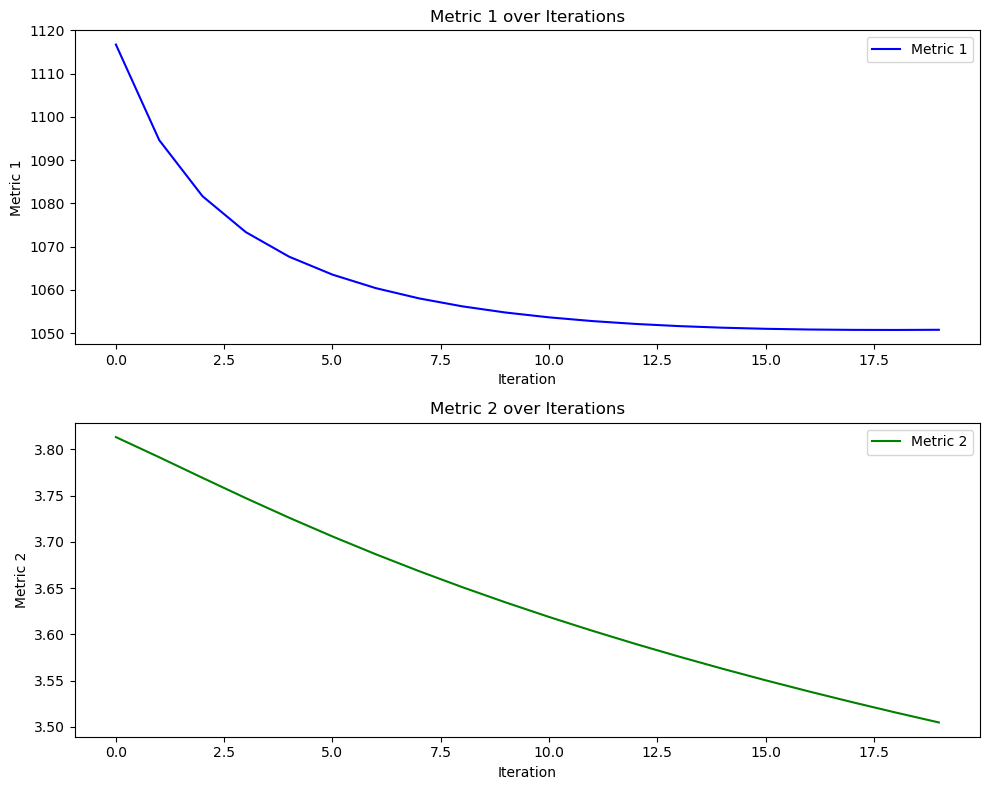

Best error achieved: 1050.7123240015349


In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import sys
import torch
import matplotlib.pyplot as plt

def convert_csv_to_matrix(input_csv, format):
    df = pd.read_csv(input_csv)
    
    df['row'] = df['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    df['col'] = df['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    
    max_row = df['row'].max()
    max_col = df['col'].max()

    if(format == "zero"):
        matrix = np.zeros((max_row, max_col))
        for index, row in df.iterrows():
            matrix[row['row']-1, row['col']-1] = row['Prediction']

    else:
        # Initialize and populate dictionary to store rows
        row_dict = {i: {} for i in range(1, max_row + 1)}
        for index, row in df.iterrows():
            row_dict[row['row']][row['col']] = row['Prediction']


        matrix = np.full((max_row, max_col), np.nan)
        for r in range(1, max_row + 1):
            for c in range(1, max_col + 1):
                if c in row_dict[r]:
                    matrix[r-1, c-1] = row_dict[r][c]
    
    return matrix

def mean_matrix(matrix):
    for r in range(matrix.shape[0]):
        row_mean = np.nanmean(matrix[r])
        matrix[r] = np.where(np.isnan(matrix[r]), row_mean, matrix[r])
    return matrix


def normalize_matrix(matrix):
    # Normalize the matrix by subtracting the row mean
    for r in range(matrix.shape[0]):
        row_mean = np.nanmean(matrix[r])
        matrix[r] = np.where(np.isnan(matrix[r]), row_mean, matrix[r]) - row_mean
    
    return matrix

def scale_matrix(matrix):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_matrix = scaler.fit_transform(matrix)
    
    return scaled_matrix

def shrink(S, shrinkage_tau):
    S[:] -= shrinkage_tau
    return torch.clamp(S, min=0)

def svd_approximation(matrix):
    shrinkage_tau = 60
    
    # SVD Decomposition
    U, S, Vh = torch.linalg.svd(matrix, full_matrices=False)

    # Set the lowest singular values to zero, e.g. S[-200:] sets the lowest 200 of the total 1000 singular values to zero
    # S[-992:] = 0
    
    # Nuclear Norm
    S = shrink(S, shrinkage_tau)
    # print(f'Non-zero singular values: {((S < -0.001) | (S > 0.001)).sum().item()}')
    
    # Return the matrix calculated by the low rank approximation
    return U @ torch.diag(S) @ Vh

def save_matrix_to_csv(matrix, relevant_values_csv, output_csv):
    # Import the relevant values csv and convert to dataframe
    relevant_values_df = pd.DataFrame(convert_csv_to_matrix(relevant_values_csv, 'zero'))
    
    matrix_df = pd.DataFrame(matrix)
    
    # Create a filtered version of the matrix. The criteria used is: relevant_values_df == 3
    filtered_matrix_df = matrix_df.where(relevant_values_df == 3, other=np.nan)
    
    # Reshape the matrix into one column and reset the index; also removes NaN values
    stacked_df = filtered_matrix_df.stack().reset_index()
    
    # Rename the columns
    stacked_df.columns = ['row', 'col', 'val']
    
    # Create the desired rN_cN format for the final output
    stacked_df['row'] = (stacked_df['row'] + 1).astype(str)
    stacked_df['col'] = (stacked_df['col'] + 1).astype(str)
    stacked_df['r_c'] = 'r' + stacked_df['row'] + '_c' + stacked_df['col']
    
    result_df = stacked_df[['r_c', 'val']]
    
    result_df.to_csv(output_csv, index=False, header=['Id', 'Prediction'])

def plot_metrics(iterations, metric1_values, metric2_values):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    ax1.plot(iterations, metric1_values, label='Metric 1', color='blue')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Metric 1')
    ax1.set_title('Metric 1 over Iterations')
    ax1.legend()
    
    ax2.plot(iterations, metric2_values, label='Metric 2', color='green')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Metric 2')
    ax2.set_title('Metric 2 over Iterations')
    ax2.legend()
    
    fig.tight_layout()
    plt.show()
    
def main(input_csv, relevant_values_csv, output_csv, format):
    matrix = convert_csv_to_matrix(input_csv, format)
    torch_matrix = torch.from_numpy(matrix)
    known_values_mask = ~torch.isnan(torch_matrix)
    
    # ---- matrices for cross validation: Comment to disable
    
    testing_values_mask = known_values_mask.clone()
    #testing_values_mask[:,:990] = False # testing data mask
    
    #known_values_mask[:,990:] = False # training data mask
    
    # ---- matrices for cross validation: Comment to disable
    
    if format == 'zero':
        pass
    elif format == 'mean':
        matrix = mean_matrix(matrix)
    elif format == 'normalize':
        # Normalize the matrix
        matrix = normalize_matrix(matrix)
    elif format == 'scale':
        # Normalize and scale the matrix
        matrix = normalize_matrix(matrix)
        matrix = scale_matrix(matrix)
    elif format == 'svd':
        # Use SVD for low rank approximation
        
        # Mean imputated matrix
        svd_matrix = torch.from_numpy(mean_matrix(matrix))
        
        # Iterate through SVD approximating and re-filling the known original values
        for iteration in range(20):
            # simple clamping
            svd_matrix = torch.clamp(svd_approximation(svd_matrix), min=1.0, max=5.0)
            
            # rescaling
            #svd_matrix = svd_approximation(svd_matrix)
            #svd_matrix = torch.from_numpy(MinMaxScaler(feature_range=(1, 5)).fit_transform(svd_matrix))
            
            # Metric on how close the approximated values match the known values
            print(f'ITERATION: {iteration:03}, Error: {torch.dist(svd_matrix[testing_values_mask], torch_matrix[testing_values_mask]).item()}')
            # print(f'Min: {torch.min(svd_matrix)}, Max: {torch.max(svd_matrix)}, Avg: {torch.mean(svd_matrix)}')
            
            # For plotting purposes only
            iterations.append(iteration)
            rmse.append(torch.dist(svd_matrix[testing_values_mask], torch_matrix[testing_values_mask]).item())
            mean.append(torch.mean(svd_matrix))
            
            # Re-fill the known original values
            svd_matrix[known_values_mask] = torch_matrix[known_values_mask]
            
        matrix = svd_matrix
        
    else:
        print(f"Unknown action: {format}")
        sys.exit(1)
    
    # Save the matrix to the output CSV
    save_matrix_to_csv(matrix, relevant_values_csv, output_csv)


iterations = []
rmse = []
mean = []
    
main('data_train.csv', 'sampleSubmission.csv', 'result.csv', "svd")
plot_metrics(iterations, rmse, mean)
print(f'Best error achieved: {min(rmse)}')

##Best results of SVD with nuclear norm (not well translatable to real scoring)
#### TAU = 150, 990 Train/10 Test
ITERATION: 007, Error: 109.83237100192804

#### TAU = 100, 990 Train/10 Test
ITERATION: 011, Error: 109.89571856902896

#### TAU = 90, 990 Train/10 Test
ITERATION: 013, Error: 109.90119514340294

#### TAU = 80, 990 Train/10 Test
ITERATION: 014, Error: 109.90792418290825

#### TAU = 70, 990 Train/10 Test
ITERATION: 017, Error: 109.91210500570742

#### TAU = 60, 990 Train/10 Test
ITERATION: 019, Error: 109.91890824509206

#### TAU = 50, 990 Train/10 Test
ITERATION: 023, Error: 109.92571334869866

#### TAU = 40, 990 Train/10 Test
ITERATION: 029, Error: 109.9270700172167